In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
from keras.engine import data_adapter
import h5py

tf.keras.backend.set_floatx('float32')

plt.rcParams.update({
    "text.usetex":True,
    "font.family":"serif"
})

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/new_ks


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v1 import Autoencoder
from tools.ESN_v1_ensembleAR import ESN_ensemble as AR_RNN
from tools.AEESN_AR_v1 import AR_AERNN_ESN as AR_AERNN
from tools.trainAEESN_ensemble import trainAERNN

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-06-24 05:37:25.316997: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-24 05:37:25.317317: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-24 05:37:25.352353: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-24 05:37:25.352606: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-24 05:37:25.352793: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [10]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print('')
print(tf.config.list_logical_devices())
print('')
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]

2.8.1


# KS System

In [11]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_ESN_ensemble/ESN_ensemble_001'

    # making AR-RNN save directory
    dir_name_ARrnn = os.getcwd() + dir_sep + 'saved_AR_AEESN_rnn'
    if not os.path.isdir(dir_name_ARrnn):
        os.makedirs(dir_name_ARrnn)

    counter = 0
    while True:
        dir_check = 'AR_ESN_ensemble_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ARrnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ARrnn = dir_name_ARrnn + dir_sep + dir_check
    os.makedirs(dir_name_ARrnn)
    os.makedirs(dir_name_ARrnn+dir_sep+'plots')
    
    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
        
    
    # training params
    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0

    loss_weights = 0.98
else:
    # AR-RNN directory
    dir_name_ARrnn = os.getcwd()+'/saved_AR_AERNN_rnn/AR_rnn_014'

    # reading AR-RNN parameters
    with open(dir_name_ARrnn + '/AR_RNN_specific_data.txt') as f:
        lines = f.readlines()
    
    params_AR_rnn_dict = eval(''.join(lines))

    dir_name_rnn = params_AR_rnn_dict['dir_name_rnn']
    rnn_idx = dir_name_rnn[-3:]
    dir_name_rnn = os.getcwd()+'/saved_ESN/ESN_'+rnn_idx

    dt_rnn = params_AR_rnn_dict['dt_rnn']
    T_sample_input = params_AR_rnn_dict['T_sample_input']
    T_sample_output = params_AR_rnn_dict['T_sample_output']
    T_offset = params_AR_rnn_dict['T_offset']
    return_params_arr = params_AR_rnn_dict['return_params_arr']
    params = params_AR_rnn_dict['params']
    try:
        normalize_dataset = params_AR_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in AR_rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_AR_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in AR_RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_AR_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in AR_RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        use_ae_data = params_AR_rnn_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in AR_RNN_specific_data, set to True.")
        use_ae_data = True
    try:
        normalization_type = params_AR_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in AR_RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'

    # training params
    with open(dir_name_ARrnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    covmat_lmda = tparams_dict['covmat_lmda']
    try:
        lambda_reg = tparams_dict['lambda_reg']
    except:
        lambda_reg = 1e-6
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0
    try:
        loss_weights = tparams_dict['loss_weights']
    except:
        loss_weights = None
    if 'freeze_layers' in tparams_dict.keys():
        freeze_layers = tparams_dict['freeze_layers']
    else:
        freeze_layers = None
    if 'clipnorm' in tparams_dict.keys():
        clipnorm = tparams_dict['clipnorm']
    else:
        clipnorm = None
    


# reading stddev
with open(dir_name_rnn + '/final_net/0_final_net_class_dict.txt') as f:
    lines = f.readlines()
finalnet_dict = eval(''.join(lines))
stddev = finalnet_dict['stddev']
# stddev = 0.0

# reading RNN normalization constants
normalization_arr_rnn = None
if normalize_dataset == True:
    with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
        lines = f.readlines()
    normarr_rnn_dict = eval(''.join(lines))
    normalization_arr_rnn = normarr_rnn_dict['normalization_arr']

if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_arr_rnn = fl['normalization_arr'][0]

# reading AE directory
with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
    lines = f.readlines()

params_dict = eval(''.join(lines))

dir_name_ae = params_dict['dir_name_ae']
ae_idx = dir_name_ae[-3:]
dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx
try:
    use_ae_data = params_dict['use_ae_data']
except:
    print("'use_ae_data' not present in sim_data_AE_params, set to True.")
    use_ae_data = True

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in ae_data, set to True.")
    ae_data_with_params = True

print('dir_name_AR_AErnn:', dir_name_ARrnn)
print('dir_name_rnn:', dir_name_rnn)
print('dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state_mat = params_dict['init_state_mat']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data']
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']
    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']


test_split = 1 - train_split - val_split

# setting seed for PRNGs
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

dir_name_AR_AErnn: /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_010
dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ESN_ensemble/ESN_ensemble_001
dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae/ae_000
data_dir_idx: 000
normalize_flag_ogdata: False


In [12]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [13]:
# delaing with normalizing the data before feeding into autoencoder
num_params = params_mat.shape[1]
og_vars = all_data.shape[1]
if alldata_withparams_flag == True:
    og_vars -= num_params

# if use_ae_data == True:
#     if ae_data_with_params == True and alldata_withparams_flag == False:
#         new_all_data = np.empty(shape=(all_data.shape[0], og_vars+num_params), dtype=FTYPE)
#         new_all_data[:, 0:og_vars] = all_data[:, 0:og_vars]
#         del(all_data)
#         all_data = new_all_data
#         prev_idx = 0
#         for i in range(boundary_idx_arr.shape[0]):
#             all_data[prev_idx:boundary_idx_arr[i], num_params:] = params_mat[i]
#             prev_idx = boundary_idx_arr[i]

#     if normalizeforae_flag == True:
#         for i in range(all_data.shape[1]):
#             all_data[:, i] -= normalization_constant_arr_aedata[0, i]
#             all_data[:, i] /= normalization_constant_arr_aedata[1, i]

#     if ae_data_with_params == False:
#         all_data = all_data[:, 0:og_vars]
# else:
#     # using raw data, neglecting the params attached (if any)
#     all_data = all_data[:, 0:og_vars]

if use_ae_data == True and ae_data_with_params == False:
    all_data = all_data[:, 0:og_vars]
else:
    all_data = all_data[:, 0:og_vars]
    
normalization_constant_arr_aedata = normalization_constant_arr_aedata[:, 0:all_data.shape[1]]

In [14]:
print('all_data.shape : ', all_data.shape)
print('all_data.dtype : ', all_data.dtype)

all_data.shape :  (500026, 64)
all_data.dtype :  float64


# Autoencoder

In [15]:
# if use_ae_data == True:
#     load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
#     wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [16]:
# if use_ae_data == True:
#     ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
#     ae_net.load_weights_from_file(wt_file)

# ESN

In [17]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = np.array([
        5,
        10,
        30,
        40,
        55,
    ])*dt_rnn/np.mean(lyapunov_time_arr)
    num_timesteps_warmup = 1*np.mean(lyapunov_time_arr)/dt_rnn
    T_sample_input = num_timesteps_warmup*dt_rnn
    T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_offset = T_sample_input
    skip_intermediate = 'full sample'
    stateful = True
    if return_params_arr != False:
        params = params_arr
    else:
        params = None

    # saving AR RNN specific data
    AR_RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'num_timesteps_warmup':num_timesteps_warmup,
        'dir_name_rnn':dir_name_rnn,
        'dir_name_ae':dir_name_ae,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':AR_RNN.__module__,
        'normalization_type':normalization_type,
        'use_ae_data':use_ae_data,
        'stateful':stateful,
    }

    with open(dir_name_ARrnn+dir_sep+'AR_RNN_specific_data.txt', 'w') as f:
        f.write(str(AR_RNN_specific_data))

In [18]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [
        [1e-3, 5e-4, 1e-4],
        [1e-4, 5e-5, 1e-5],
        [1e-5, 5e-6, 1e-6],
        [1e-6, 5e-7, 1e-7],
#         [1e-6, 5e-7, 1e-7],
        [1e-7, 5e-8, 1e-8],
        [1e-7, 5e-8, 1e-8],
    ]
    epochs = [
        [200]*3,
        [200]*3,
        [200]*3,
        [200]*3,
        [200]*3,
    ]
    patience = [
        [10]*3,
        [10]*3,#[25],
        [10]*3,#[30],
        [10]*3,#[35],
        [10]*3,#[40],
    ] # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 7e-9  # weight for regularizer
    covmat_lmda = 5e-5  # weight for the covmat loss

    if loss_weights is None:
        loss_weights = 1.0
        
    freeze_layers = [
        [],
        [],
        [],
    ]
    
    clipnorm = None #1.0
    batch_size = 32
    
    train_alpha = [False]*3
    train_omega_in = [False]*3
    train_rho_res = [False]*3
    
    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'loss_weights':loss_weights,
        'stddev':stddev,
        'covmat_lmda':covmat_lmda,
        'freeze_layers':freeze_layers,
        'clipnorm':clipnorm,
        'lambda_reg':lambda_reg,
    }

    with open(dir_name_ARrnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_ARrnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr_rnn],
    )

In [19]:
rnn_kwargs = {}
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    load_file_rnn = dir_name_rnn + '/final_net/final_net_class_dict.txt'
    wt_file_rnn = dir_name_rnn+'/final_net/final_net_ESN_weights.hdf5'
    
    load_file_ae = dir_name_ae+'/final_net/final_net_class_dict.txt'
    wt_file_ae = dir_name_ae+'/final_net/final_net_ae_weights.h5'
    
    rnn_kwargs = {
        'train_alpha':train_alpha,
        'train_omega_in':train_omega_in,
        'train_rho_res':train_rho_res,
    }

In [20]:
def find_and_return_load_wt_file_lists(
        load_dir,
        wt_matcher='weights.hdf5',
        classdict_matcher='class_dict.txt',
    ):
    contents_load_dir = [f for f in os.listdir(load_dir) if os.path.isfile(os.path.join(load_dir, f))]
    load_files_lst = [f for f in contents_load_dir if f.endswith(classdict_matcher)]
    wt_files_lst = [f for f in contents_load_dir if f.endswith(wt_matcher)]

    load_files_lst_startingidx = []
    for i in range(len(load_files_lst)):
        fn = load_files_lst[i]
        idx = fn.find('_')
        load_files_lst_startingidx.append(int(fn[0:idx]))

    wt_files_lst_startingidx = []
    for i in range(len(wt_files_lst)):
        fn = wt_files_lst[i]
        idx = fn.find('_')
        wt_files_lst_startingidx.append(int(fn[0:idx]))

    load_files_sortidx = np.argsort(load_files_lst_startingidx)
    wt_files_sortidx = np.argsort(wt_files_lst_startingidx)

    load_files_lst = np.array(load_files_lst)[load_files_sortidx]
    wt_files_lst = np.array(wt_files_lst)[wt_files_sortidx]

    load_file_rnn = [load_dir + '/' + fn for fn in load_files_lst]
    wt_file_rnn = [load_dir + '/' +  fn for fn in wt_files_lst]
    
    return load_file_rnn, wt_file_rnn

In [21]:
load_dir = dir_name_rnn + '/final_net'
load_file_rnn, wt_file_rnn = find_and_return_load_wt_file_lists(load_dir)



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 5 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : None
9/9 [==============================] - 15s 579ms/step - loss: 7.7837e-04 - mse: 7.5807e-05 - NMSE: 6.8215e-04 - NMSE_wt: 6.4312e-04 - covmat_fro_loss: 0.0000e+00 - global_gradnorm: 0.0000e+00
baseline : 6.8215E-04


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
76/76 [==============================] - ETA: 0s - loss: 0.2607 - mse: 0.0304 - NMSE: 0.2738 - NMSE_wt: 0.2606 - covmat_fro_loss: 0.0095 - global_gradnorm: 3.1431 - tot_time: 0h 2m 13.7s

Epoch 1: val_NMSE did not improve from 0.00068
 - 

76/76 [==============================] - ETA: 0s - loss: 0.0098 - mse: 0.0011 - NMSE: 0.0102 - NMSE_wt: 0.0097 - covmat_fro_loss: 0.0020 - global_gradnorm: 0.4245 - tot_time: 0h 19m 26.9s

Epoch 1: val_NMSE did not improve from 0.00068
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_010/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 104s 1s/step - loss: 0.0098 - mse: 0.0011 - NMSE: 0.0102 - NMSE_wt: 0.0097 - covmat_fro_loss: 0.0020 - global_gradnorm: 0.4243 - val_loss: 0.0093 - val_mse: 0.0011 - val_NMSE: 0.0097 - val_NMSE_wt: 0.0092 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 2/200
76/76 [==============================] - ETA: 0s - loss: 0.0078 - mse: 9.0305e-04 - NMSE: 0.0081 - NMSE_wt: 0.0077 - covmat_fro_loss: 0.0018 - global_gradnorm: 0.4297 - tot_time: 0h 21m 10.7s

Epoch 2: val_NMSE did not improve from 0.00068
 - saving loss histories at /home/rkaus

76/76 [==============================] - ETA: 0s - loss: 0.0079 - mse: 9.1776e-04 - NMSE: 0.0083 - NMSE_wt: 0.0078 - covmat_fro_loss: 0.0018 - global_gradnorm: 0.3969 - tot_time: 0h 38m 23.7s

Epoch 12: val_NMSE did not improve from 0.00068
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_010/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 104s 1s/step - loss: 0.0079 - mse: 9.1776e-04 - NMSE: 0.0083 - NMSE_wt: 0.0078 - covmat_fro_loss: 0.0018 - global_gradnorm: 0.3959 - val_loss: 0.0060 - val_mse: 6.8996e-04 - val_NMSE: 0.0062 - val_NMSE_wt: 0.0059 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 13/200
76/76 [==============================] - ETA: 0s - loss: 0.0064 - mse: 7.4165e-04 - NMSE: 0.0067 - NMSE_wt: 0.0063 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.3387 - tot_time: 0h 40m 7.5s

Epoch 13: val_NMSE did not improve from 0.00068
 - saving loss histories 

Epoch 4/200
76/76 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.7639e-04 - NMSE: 0.0025 - NMSE_wt: 0.0024 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.1416 - tot_time: 0h 57m 21.3s

Epoch 4: val_NMSE did not improve from 0.00068
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_010/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 103s 1s/step - loss: 0.0025 - mse: 2.7639e-04 - NMSE: 0.0025 - NMSE_wt: 0.0024 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.1417 - val_loss: 0.0026 - val_mse: 2.8753e-04 - val_NMSE: 0.0026 - val_NMSE_wt: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 5/200
76/76 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.7734e-04 - NMSE: 0.0025 - NMSE_wt: 0.0024 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.1525 - tot_time: 0h 59m 4.0s

Epoch 5: val_NMSE did not improve from 0.00068
 - saving loss h

76/76 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.4255e-04 - NMSE: 0.0022 - NMSE_wt: 0.0021 - covmat_fro_loss: 9.6236e-04 - global_gradnorm: 0.1370 - tot_time: 1h 16m 20.6s

Epoch 15: val_NMSE did not improve from 0.00068
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_010/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 104s 1s/step - loss: 0.0022 - mse: 2.4255e-04 - NMSE: 0.0022 - NMSE_wt: 0.0021 - covmat_fro_loss: 9.6182e-04 - global_gradnorm: 0.1372 - val_loss: 0.0026 - val_mse: 2.8573e-04 - val_NMSE: 0.0026 - val_NMSE_wt: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 16/200
76/76 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.5179e-04 - NMSE: 0.0023 - NMSE_wt: 0.0021 - covmat_fro_loss: 9.8175e-04 - global_gradnorm: 0.1555 - tot_time: 1h 18m 4.4s

Epoch 16: val_NMSE did not improve from 0.00068
 - saving los

76/76 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.6038e-04 - NMSE: 0.0023 - NMSE_wt: 0.0022 - covmat_fro_loss: 9.9773e-04 - global_gradnorm: 0.1854 - tot_time: 1h 35m 21.2s

Epoch 26: val_NMSE did not improve from 0.00068
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_010/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 103s 1s/step - loss: 0.0023 - mse: 2.6038e-04 - NMSE: 0.0023 - NMSE_wt: 0.0022 - covmat_fro_loss: 9.9819e-04 - global_gradnorm: 0.1850 - val_loss: 0.0024 - val_mse: 2.6485e-04 - val_NMSE: 0.0024 - val_NMSE_wt: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 27/200
76/76 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.5532e-04 - NMSE: 0.0023 - NMSE_wt: 0.0022 - covmat_fro_loss: 9.8471e-04 - global_gradnorm: 0.1737 - tot_time: 1h 37m 4.8s

Epoch 27: val_NMSE did not improve from 0.00068
 - saving los

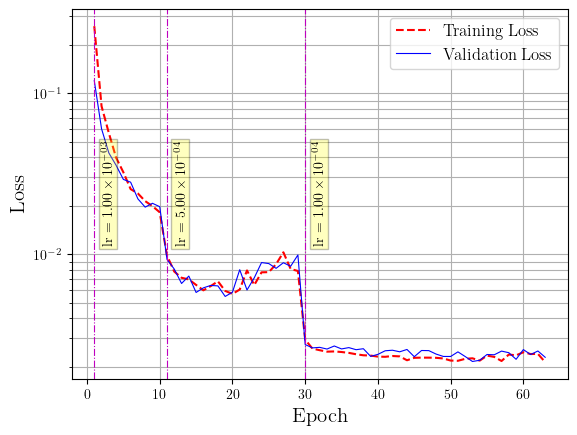

<Figure size 640x480 with 0 Axes>

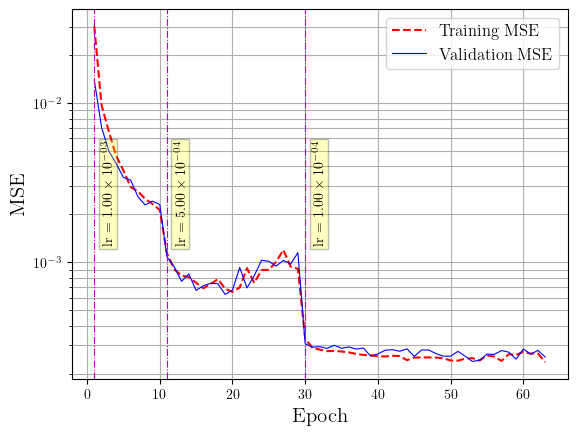

<Figure size 640x480 with 0 Axes>

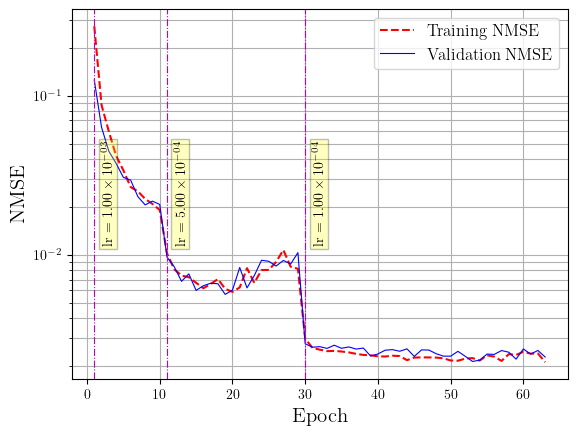

<Figure size 640x480 with 0 Axes>

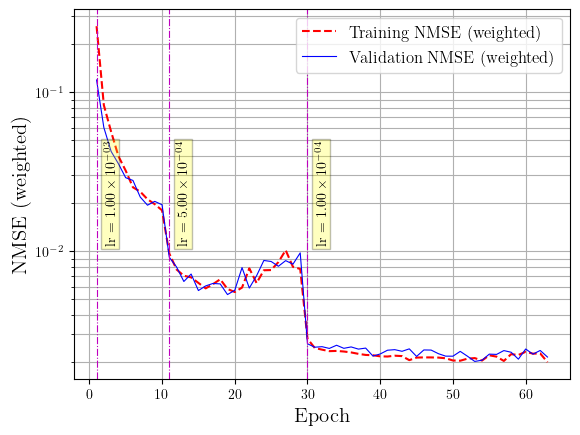

<Figure size 640x480 with 0 Axes>

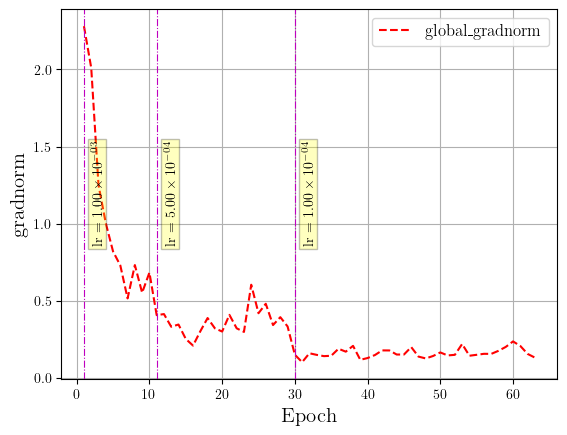



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 10 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 3.0
8/8 [==============================] - 23s 650ms/step - loss: 0.0049 - mse: 5.9983e-04 - NMSE: 0.0054 - NMSE_wt: 0.0047 - covmat_fro_loss: 0.0000e+00 - global_gradnorm: 0.0000e+00
baseline : 5.3976E-03


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
71/71 [==============================] - ETA: 0s - loss: 0.0115 - mse: 0.0014 - NMSE: 0.0129 - NMSE_wt: 0.0113 - covmat_fro_loss: 0.0041 - global_gradnorm: 0.4824 - tot_time: 0h 2m 47.3s

Epoch 1: val_NMSE did not improve from 0.00540
 - saving loss h



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 5e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
71/71 [==============================] - ETA: 0s - loss: 0.0047 - mse: 5.8014e-04 - NMSE: 0.0052 - NMSE_wt: 0.0046 - covmat_fro_loss: 0.0026 - global_gradnorm: 0.2632 - tot_time: 0h 20m 38.2s

Epoch 1: val_NMSE improved from 0.00540 to 0.00493, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_010/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_010/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 108s 2s/step - loss: 0.0047 - mse: 5.8014e-04 - NMSE: 0.0052 - NMSE_wt: 0.0046 - covmat_fro_loss: 0.0026 - global_gradnorm: 0.2629 - val_loss: 0.0045 - val_ms

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_010/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 107s 2s/step - loss: 0.0041 - mse: 5.0686e-04 - NMSE: 0.0046 - NMSE_wt: 0.0040 - covmat_fro_loss: 0.0024 - global_gradnorm: 0.2334 - val_loss: 0.0044 - val_mse: 5.3952e-04 - val_NMSE: 0.0049 - val_NMSE_wt: 0.0043 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 12/200
71/71 [==============================] - ETA: 0s - loss: 0.0044 - mse: 5.4491e-04 - NMSE: 0.0049 - NMSE_wt: 0.0043 - covmat_fro_loss: 0.0025 - global_gradnorm: 0.2474 - tot_time: 0h 40m 16.7s

Epoch 12: val_NMSE did not improve from 0.00438
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_010/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 106s 2s/step - loss: 0.0044 - mse: 5.4491e-04 - NMSE: 0.0049 - 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_010/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 107s 2s/step - loss: 0.0031 - mse: 3.7049e-04 - NMSE: 0.0033 - NMSE_wt: 0.0029 - covmat_fro_loss: 0.0021 - global_gradnorm: 0.1338 - val_loss: 0.0032 - val_mse: 3.9150e-04 - val_NMSE: 0.0035 - val_NMSE_wt: 0.0031 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 9/200
71/71 [==============================] - ETA: 0s - loss: 0.0031 - mse: 3.6933e-04 - NMSE: 0.0033 - NMSE_wt: 0.0029 - covmat_fro_loss: 0.0021 - global_gradnorm: 0.1331 - tot_time: 0h 58m 7.9s

Epoch 9: val_NMSE improved from 0.00352 to 0.00346, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_010/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_010/checkpoints/Los

71/71 [==============================] - ETA: 0s - loss: 0.0030 - mse: 3.6360e-04 - NMSE: 0.0033 - NMSE_wt: 0.0029 - covmat_fro_loss: 0.0021 - global_gradnorm: 0.1363 - tot_time: 1h 15m 58.8s

Epoch 19: val_NMSE did not improve from 0.00343
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_010/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 107s 2s/step - loss: 0.0030 - mse: 3.6360e-04 - NMSE: 0.0033 - NMSE_wt: 0.0029 - covmat_fro_loss: 0.0021 - global_gradnorm: 0.1361 - val_loss: 0.0032 - val_mse: 3.9050e-04 - val_NMSE: 0.0035 - val_NMSE_wt: 0.0031 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 20/200
71/71 [==============================] - ETA: 0s - loss: 0.0030 - mse: 3.6440e-04 - NMSE: 0.0033 - NMSE_wt: 0.0029 - covmat_fro_loss: 0.0021 - global_gradnorm: 0.1349 - tot_time: 1h 17m 45.7s

Epoch 20: val_NMSE did not improve from 0.00343
 - saving loss historie

Epoch 30/200
71/71 [==============================] - ETA: 0s - loss: 0.0030 - mse: 3.5677e-04 - NMSE: 0.0032 - NMSE_wt: 0.0028 - covmat_fro_loss: 0.0020 - global_gradnorm: 0.1406 - tot_time: 1h 35m 38.4s

Epoch 30: val_NMSE did not improve from 0.00336
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_010/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 107s 2s/step - loss: 0.0030 - mse: 3.5677e-04 - NMSE: 0.0032 - NMSE_wt: 0.0028 - covmat_fro_loss: 0.0020 - global_gradnorm: 0.1404 - val_loss: 0.0031 - val_mse: 3.7641e-04 - val_NMSE: 0.0034 - val_NMSE_wt: 0.0030 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 31/200
71/71 [==============================] - ETA: 0s - loss: 0.0029 - mse: 3.5492e-04 - NMSE: 0.0032 - NMSE_wt: 0.0028 - covmat_fro_loss: 0.0020 - global_gradnorm: 0.1356 - tot_time: 1h 37m 25.4s

Epoch 31: val_NMSE did not improve from 0.00336
 - saving 

Epoch 41/200
71/71 [==============================] - ETA: 0s - loss: 0.0029 - mse: 3.4704e-04 - NMSE: 0.0031 - NMSE_wt: 0.0027 - covmat_fro_loss: 0.0020 - global_gradnorm: 0.1360 - tot_time: 1h 55m 16.8s

Epoch 41: val_NMSE did not improve from 0.00328
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_010/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 107s 2s/step - loss: 0.0029 - mse: 3.4704e-04 - NMSE: 0.0031 - NMSE_wt: 0.0027 - covmat_fro_loss: 0.0020 - global_gradnorm: 0.1362 - val_loss: 0.0031 - val_mse: 3.7918e-04 - val_NMSE: 0.0034 - val_NMSE_wt: 0.0030 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 42/200
71/71 [==============================] - ETA: 0s - loss: 0.0029 - mse: 3.4572e-04 - NMSE: 0.0031 - NMSE_wt: 0.0027 - covmat_fro_loss: 0.0020 - global_gradnorm: 0.1323Restoring model weights from the end of the best epoch: 32.
 - tot_time: 1h 57m 4.1s


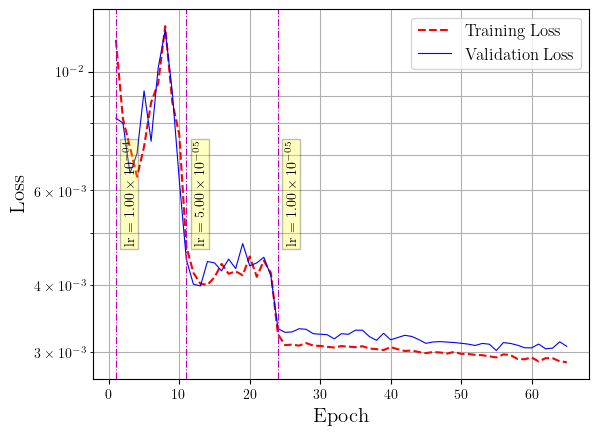

<Figure size 640x480 with 0 Axes>

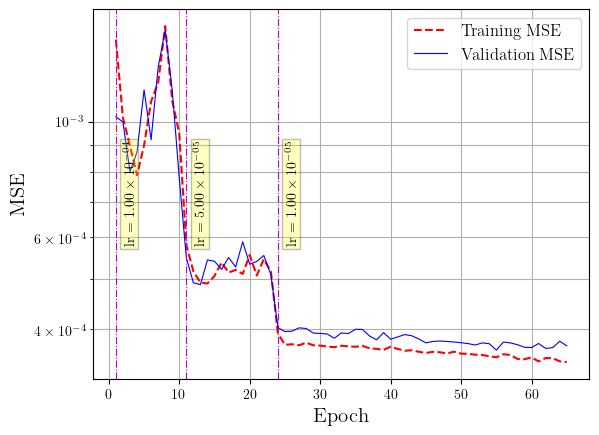

<Figure size 640x480 with 0 Axes>

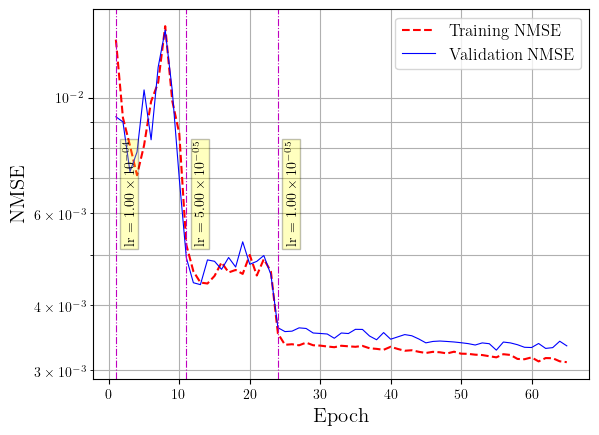

<Figure size 640x480 with 0 Axes>

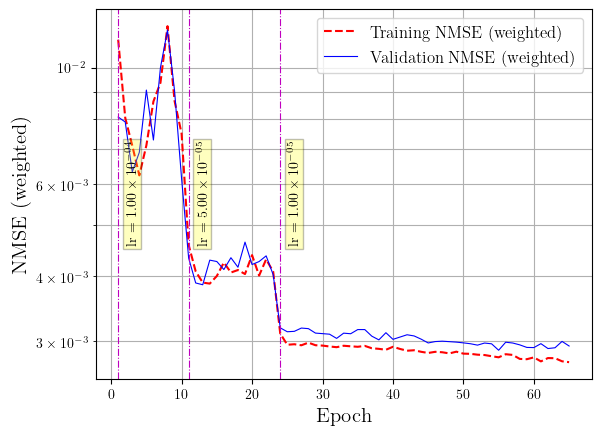

<Figure size 640x480 with 0 Axes>

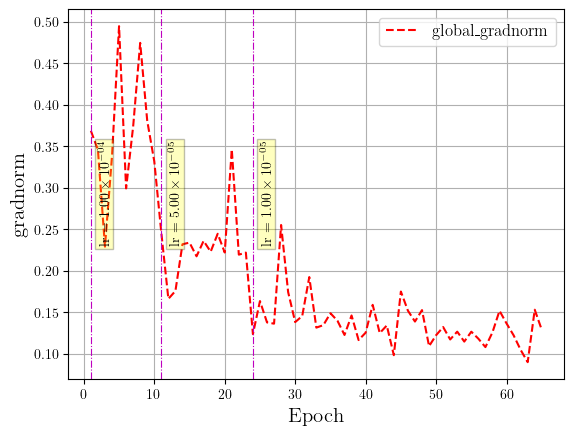



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 30 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 3.0
7/7 [==============================] - 62s 856ms/step - loss: 0.0167 - mse: 0.0029 - NMSE: 0.0258 - NMSE_wt: 0.0166 - covmat_fro_loss: 0.0000e+00 - global_gradnorm: 0.0000e+00
baseline : 2.5761E-02


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
58/58 [==============================] - ETA: 0s - loss: 0.0172 - mse: 0.0029 - NMSE: 0.0265 - NMSE_wt: 0.0171 - covmat_fro_loss: 0.0105 - global_gradnorm: 0.3096 - tot_time: 0h 5m 12.3s

Epoch 1: val_NMSE improved from 0.02576 to 0.02495, saving model to

Epoch 11/200
58/58 [==============================] - ETA: 0s - loss: 0.0156 - mse: 0.0027 - NMSE: 0.0239 - NMSE_wt: 0.0155 - covmat_fro_loss: 0.0100 - global_gradnorm: 0.2773 - tot_time: 0h 25m 7.6s

Epoch 11: val_NMSE did not improve from 0.02400
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_010/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 120s 2s/step - loss: 0.0156 - mse: 0.0027 - NMSE: 0.0239 - NMSE_wt: 0.0155 - covmat_fro_loss: 0.0100 - global_gradnorm: 0.2776 - val_loss: 0.0174 - val_mse: 0.0030 - val_NMSE: 0.0267 - val_NMSE_wt: 0.0173 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 12/200
58/58 [==============================] - ETA: 0s - loss: 0.0158 - mse: 0.0027 - NMSE: 0.0241 - NMSE_wt: 0.0156 - covmat_fro_loss: 0.0101 - global_gradnorm: 0.2915 - tot_time: 0h 27m 7.0s

Epoch 12: val_NMSE did not improve from 0.02400
 - saving loss histories at 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_010/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 119s 2s/step - loss: 0.0145 - mse: 0.0025 - NMSE: 0.0221 - NMSE_wt: 0.0143 - covmat_fro_loss: 0.0096 - global_gradnorm: 0.2374 - val_loss: 0.0158 - val_mse: 0.0027 - val_NMSE: 0.0242 - val_NMSE_wt: 0.0156 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 7/200
58/58 [==============================] - ETA: 0s - loss: 0.0146 - mse: 0.0025 - NMSE: 0.0223 - NMSE_wt: 0.0144 - covmat_fro_loss: 0.0096 - global_gradnorm: 0.2537 - tot_time: 0h 47m 2.5s

Epoch 7: val_NMSE did not improve from 0.02320
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_010/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 120s 2s/step - loss: 0.0146 - mse: 0.0025 - NMSE: 0.0223 - NMSE_wt: 0.0144 - c

Epoch 18/200
58/58 [==============================] - ETA: 0s - loss: 0.0144 - mse: 0.0025 - NMSE: 0.0221 - NMSE_wt: 0.0143 - covmat_fro_loss: 0.0096 - global_gradnorm: 0.2571Restoring model weights from the end of the best epoch: 8.
 - tot_time: 1h 8m 56.0s

Epoch 18: val_NMSE did not improve from 0.02296
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_010/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 120s 2s/step - loss: 0.0144 - mse: 0.0025 - NMSE: 0.0221 - NMSE_wt: 0.0143 - covmat_fro_loss: 0.0096 - global_gradnorm: 0.2567 - val_loss: 0.0159 - val_mse: 0.0027 - val_NMSE: 0.0245 - val_NMSE_wt: 0.0158 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 18: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-06 -----------------------------

---------------------------

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_010/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 120s 2s/step - loss: 0.0136 - mse: 0.0023 - NMSE: 0.0208 - NMSE_wt: 0.0134 - covmat_fro_loss: 0.0093 - global_gradnorm: 0.2219 - val_loss: 0.0146 - val_mse: 0.0025 - val_NMSE: 0.0224 - val_NMSE_wt: 0.0145 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 11/200
58/58 [==============================] - ETA: 0s - loss: 0.0135 - mse: 0.0023 - NMSE: 0.0207 - NMSE_wt: 0.0134 - covmat_fro_loss: 0.0092 - global_gradnorm: 0.2193 - tot_time: 1h 30m 52.0s

Epoch 11: val_NMSE did not improve from 0.02223
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AEESN_rnn/AR_ESN_ensemble_010/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 120s 2s/step - loss: 0.0135 - mse: 0.0023 - NMSE: 0.0207 - NMSE_wt: 0.0134 

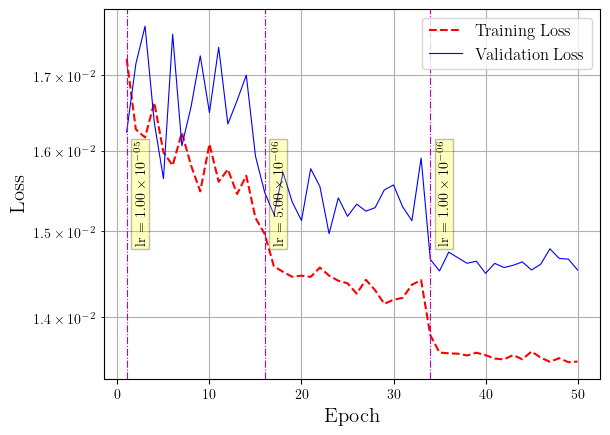

<Figure size 640x480 with 0 Axes>

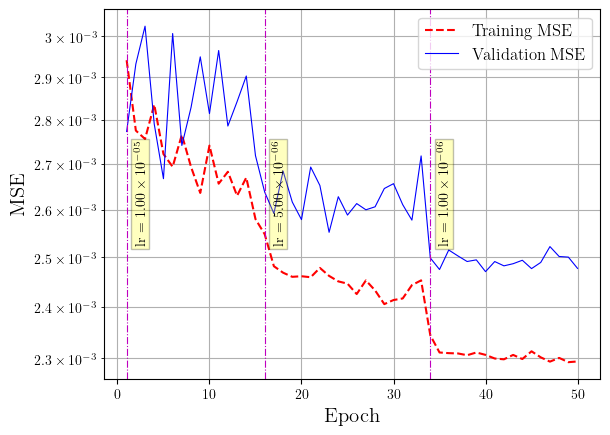

<Figure size 640x480 with 0 Axes>

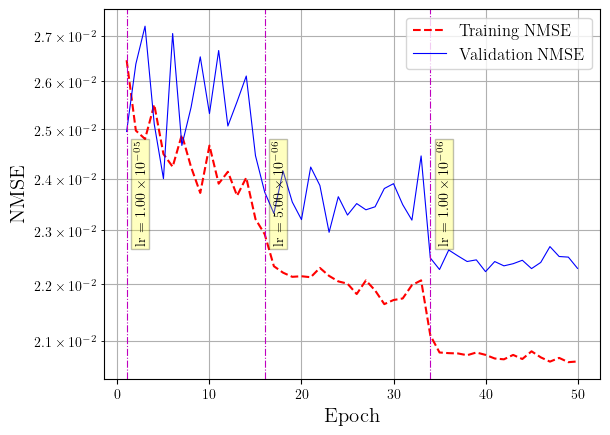

<Figure size 640x480 with 0 Axes>

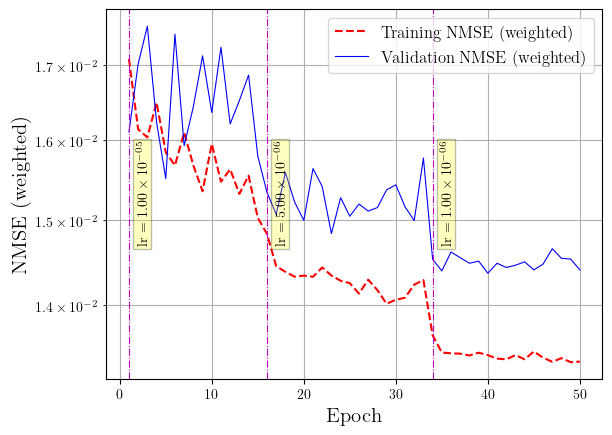

<Figure size 640x480 with 0 Axes>

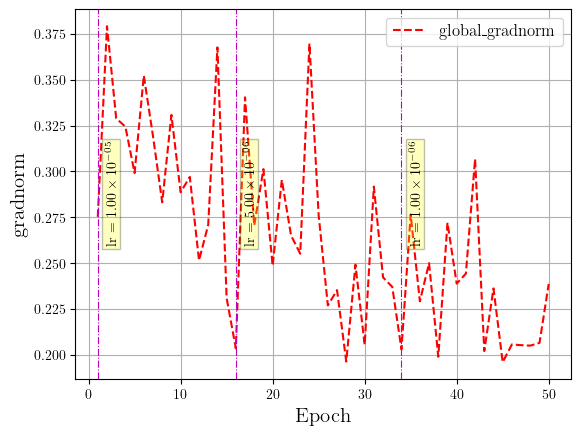



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 40 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 3.0
6/6 [==============================] - 87s 947ms/step - loss: 0.0246 - mse: 0.0049 - NMSE: 0.0445 - NMSE_wt: 0.0245 - covmat_fro_loss: 0.0000e+00 - global_gradnorm: 0.0000e+00
baseline : 4.4504E-02


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-06 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200


2023-06-24 11:16:33.878778: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 75.20MiB (rounded to 78848000)requested by op gradient_tape/strided_slice_9/StridedSliceGrad
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-06-24 11:16:33.879626: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2023-06-24 11:16:33.879646: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 4595, Chunks in use: 4595. 1.12MiB allocated for chunks. 1.12MiB in use in bin. 57.0KiB client-requested in use in bin.
2023-06-24 11:16:33.879653: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 100, Chunks in use: 96. 51.8KiB allocated for chunks. 49.0KiB in use in bin. 42.0KiB client-requested i

2023-06-24 11:16:34.034586: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 13049b1300 of size 256 next 6861
2023-06-24 11:16:34.034594: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 13049b1400 of size 256 next 1020
2023-06-24 11:16:34.034604: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 13049b1500 of size 256 next 2740
2023-06-24 11:16:34.034612: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 13049b1600 of size 256 next 4326
2023-06-24 11:16:34.034620: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 13049b1700 of size 256 next 566
2023-06-24 11:16:34.034628: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 13049b1800 of size 256 next 474
2023-06-24 11:16:34.034636: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 13049b1900 of size 256 next 2120
2023-06-24 11:16:34.034645: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 13049b1a00 of size 256 next

2023-06-24 11:16:34.247009: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 1338481a00 of size 256 next 3860
2023-06-24 11:16:34.247019: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 1338481b00 of size 256 next 816
2023-06-24 11:16:34.247029: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 1338481c00 of size 256 next 4386
2023-06-24 11:16:34.247039: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 1338481d00 of size 256 next 6453
2023-06-24 11:16:34.247049: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 1338481e00 of size 256 next 1311
2023-06-24 11:16:34.247059: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 1338481f00 of size 256 next 646
2023-06-24 11:16:34.247069: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 1338482000 of size 256 next 2496
2023-06-24 11:16:34.247079: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 1338482100 of size 256 next

2023-06-24 11:16:44.356989: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 75.20MiB (rounded to 78848000)requested by op gradient_tape/strided_slice_7/StridedSliceGrad
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-06-24 11:16:44.357969: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2023-06-24 11:16:44.358019: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 4595, Chunks in use: 4595. 1.12MiB allocated for chunks. 1.12MiB in use in bin. 57.0KiB client-requested in use in bin.
2023-06-24 11:16:44.358040: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 100, Chunks in use: 96. 51.8KiB allocated for chunks. 49.0KiB in use in bin. 42.0KiB client-requested i

2023-06-24 11:16:44.517943: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 1359666e00 of size 1024000 next 3427
2023-06-24 11:16:44.517953: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] Free  at 1359760e00 of size 8192000 next 6555
2023-06-24 11:16:44.517963: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 1359f30e00 of size 1024000 next 8077
2023-06-24 11:16:44.517974: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 135a02ae00 of size 1024000 next 6828
2023-06-24 11:16:44.517984: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 135a124e00 of size 1024000 next 7866
2023-06-24 11:16:44.517994: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 135a21ee00 of size 1024000 next 7758
2023-06-24 11:16:44.518004: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 135a318e00 of size 1024000 next 360
2023-06-24 11:16:44.518014: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse a

2023-06-24 11:16:54.585905: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 75.20MiB (rounded to 78848000)requested by op gradient_tape/rnn_30/transpose_1/transpose
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-06-24 11:16:54.586823: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2023-06-24 11:16:54.586853: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 4595, Chunks in use: 4595. 1.12MiB allocated for chunks. 1.12MiB in use in bin. 57.0KiB client-requested in use in bin.
2023-06-24 11:16:54.586873: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 100, Chunks in use: 96. 51.8KiB allocated for chunks. 49.0KiB in use in bin. 42.0KiB client-requested in us

2023-06-24 11:16:54.786725: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 133846ba00 of size 256 next 8026
2023-06-24 11:16:54.786743: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 133846bb00 of size 256 next 5295
2023-06-24 11:16:54.786755: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 133846bc00 of size 256 next 1975
2023-06-24 11:16:54.786765: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 133846bd00 of size 256 next 7149
2023-06-24 11:16:54.786775: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 133846be00 of size 256 next 5264
2023-06-24 11:16:54.786786: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 133846bf00 of size 256 next 6993
2023-06-24 11:16:54.786796: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 133846c000 of size 256 next 5079
2023-06-24 11:16:54.786806: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 133846c100 of size 256 ne

ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/strided_slice_9/StridedSliceGrad' defined at (most recent call last):
    File "/home/rkaushik/miniconda3/envs/tf-gpu/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/rkaushik/miniconda3/envs/tf-gpu/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/rkaushik/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/rkaushik/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/traitlets/config/application.py", line 978, in launch_instance
      app.start()
    File "/home/rkaushik/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/rkaushik/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/rkaushik/miniconda3/envs/tf-gpu/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/home/rkaushik/miniconda3/envs/tf-gpu/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/home/rkaushik/miniconda3/envs/tf-gpu/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/rkaushik/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/rkaushik/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/rkaushik/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/rkaushik/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/rkaushik/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/rkaushik/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/rkaushik/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2885, in run_cell
      result = self._run_cell(
    File "/home/rkaushik/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "/home/rkaushik/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/rkaushik/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3139, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/rkaushik/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3318, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/rkaushik/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3378, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_1537985/3223879888.py", line 41, in <module>
      trainAERNN(
    File "/home/rkaushik/Documents/Thesis/MLROM/new_ks/tools/trainAEESN_ensemble.py", line 500, in trainAERNN
      history = AR_AERNN_net.fit(training_data_rnn_input, training_data_rnn_output,
    File "/home/rkaushik/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/rkaushik/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/rkaushik/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/home/rkaushik/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/rkaushik/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/home/rkaushik/Documents/Thesis/MLROM/new_ks/tools/AEESN_AR_v1.py", line 412, in train_step
      gradients = tape.gradient(loss, trainable_vars)
Node: 'gradient_tape/strided_slice_9/StridedSliceGrad'
OOM when allocating tensor with shape[32,77,8000] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/strided_slice_9/StridedSliceGrad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1709200]

In [22]:
global_clipnorm = None
for kk in range(len(T_sample_output)):

    num_outsteps = int((T_sample_output[kk] + 0.5*dt_rnn)//dt_rnn)
    if type(freeze_layers) == type(None):
        freeze_layers_thisoutstep = []
    else:
        if kk > len(freeze_layers) - 1:
            freeze_layers_thisoutstep = freeze_layers[-1]
        else:
            freeze_layers_thisoutstep = freeze_layers[kk]
        
        if type(freeze_layers_thisoutstep) == type(None):
            freeze_layers_thisoutstep = []

    total_s_len = 80
    sep_lr_s = ' num_outsteps : {} '.format(num_outsteps)
    sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'>' + sep_lr_s
    sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'<'
    print('\n\n' + '*'*len(sep_lr_s))
    print('' + sep_lr_s+'')
    print('*'*len(sep_lr_s) + '\n\n')

    if behaviour == 'loadCheckpointAndContinueTraining':
        if kk < len(T_sample_output) - 1:
            temp = int((T_sample_output[kk+1] + 0.5*dt_rnn)//dt_rnn)
        else:
            temp = num_outsteps
        checkfile1 = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_rnn_weights.hdf5'.format(temp)
        checkfile2 = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_ae_weights.h5'.format(temp)
        check1 = os.path.exists(checkfile1)
        check2 = os.path.exists(checkfile2)
        if check1 and check2:
            # move on to checking the next time-step
            continue
        else:
            pass
    
    print('clipnorm : {}, global_clipnorm : {}'.format(clipnorm, global_clipnorm))
    
    trainAERNN(
        create_data_for_RNN,
        Autoencoder,
        AR_RNN,
        all_data,
        AR_AERNN,
        dt_rnn=dt_rnn,
        T_sample_input=T_sample_input,
        T_sample_output=T_sample_output[kk],
        T_offset=T_offset,
        boundary_idx_arr=boundary_idx_arr,
        delta_t=delta_t,
        params=params,
        normalize_dataset=normalize_dataset,
        stddev_multiplier=stddev_multiplier,
        skip_intermediate=skip_intermediate,
        normalization_type=normalization_type,
        normalization_constant_arr_aedata=normalization_constant_arr_aedata,
        normalization_constant_arr_rnndata=normalization_arr_rnn,
        learning_rate_list=learning_rate_list[kk],
        epochs=epochs[kk],
        patience=patience[kk],
        loss_weights=loss_weights,
        min_delta=min_delta,
        lambda_reg=lambda_reg,
        stddev_rnn=stddev,
        stateful=False,
        behaviour=behaviour,
        strategy=strategy,
        dir_name_rnn=dir_name_rnn,
        dir_name_AR_AErnn=dir_name_ARrnn,
        batch_size=batch_size,
        load_file_rnn=load_file_rnn,
        wt_file_rnn=wt_file_rnn,
        load_file_ae=load_file_ae,
        wt_file_ae=wt_file_ae,
        covmat_lmda=covmat_lmda,
        readAndReturnLossHistories=readAndReturnLossHistories,
        mytimecallback=mytimecallback,
        plot_losses=plot_losses,
        SaveLosses=SaveLosses,
        train_split=train_split,
        test_split=test_split,
        val_split=val_split,
        freeze_layers=freeze_layers_thisoutstep,
        clipnorm=clipnorm,
        global_clipnorm=global_clipnorm,
        ESN_flag=True,
        rnn_kwargs=rnn_kwargs,
    )
    
    
    load_dir = dir_name_ARrnn+'/final_net/{}_outsteps'.format(num_outsteps)
    load_file_rnn, wt_file_rnn = find_and_return_load_wt_file_lists(
        load_dir,
        wt_matcher='ESN_weights.hdf5',
        classdict_matcher='ESN_class_dict.txt'
    )
    
    load_file_ae = load_dir + '/final_net-{}_outsteps_ae_class_dict.txt'.format(num_outsteps)
    wt_file_ae = load_dir + '/final_net-{}_outsteps_ae_weights.h5'.format(num_outsteps)
    
    with open(load_dir+'/losses-{}_outsteps.txt'.format(num_outsteps), 'r') as fl:
        lines = fl.readlines()

    loss_dict = eval(''.join(lines))
    train_global_gradnorm_hist = loss_dict['train_global_gradnorm_hist']
    # lr_change = loss_dict['lr_change']
    # trained_epochs = len(train_global_gradnorm_hist)
    # if lr_change[-1] - lr_change[-2] == epochs[kk][-1]:
    #     global_clipnorm = train_global_gradnorm_hist[-1]
    # else:
    #     global_clipnorm = train_global_gradnorm_hist[-patience[kk][-1]]

    # alpha1 = 0.9
    # alpha2 = 0.1
    # global_clipnorm = train_global_gradnorm_hist[0]
    # for i in range(1, len(train_global_gradnorm_hist)):
    #     global_clipnorm = alpha1*global_clipnorm + alpha2*train_global_gradnorm_hist[i]

    idxs_to_ignore = 0
    global_clipnorm_min = 3.0
    global_clipnorm = np.max(train_global_gradnorm_hist[idxs_to_ignore:])
    global_clipnorm = 0.1 * np.round(10*global_clipnorm)
    global_clipnorm = max(global_clipnorm, global_clipnorm_min)

In [ ]:
### Training the combined AE-RNN


# 